In [1]:
%matplotlib notebook
%reload_ext autoreload
%autoreload 2

import sys
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

sys.path.append('../../')
from vis.utils import transform as tr

plt.rcParams.update({'figure.max_open_warning': 0})

In [2]:
sys.path.append('../../')
from vis.utils import sampling as smp

def rf(x, k=1):
    r"""The radius function for the knee problem.
    """
    return 5.0 + (10.0 * (x - 0.5) * (x - 0.5)) \
            + ((2.0 / k) * np.cos(2.0 * k * np.pi * x))

def getX(F):
    m = F.shape[1]
    X = np.zeros((F.shape[0], m-1))
    for i in range(m-2):
        denom = np.linalg.norm(F[:,i:m], 2, axis=1)
        Inz = np.nonzero(denom)
        X[Inz,i] = np.arccos(F[Inz,i] / denom[Inz]) / (np.pi / 2)

    denom = np.linalg.norm(F[:,m-2:m], 2, axis=1)
    Inz = np.nonzero(denom)
    X[Inz,m-2] = np.arccos(F[Inz,m-2] / denom[Inz]) / (np.pi / 2)
    return X

def debmdk_knee_region(r=1, n=100, m=3, lb=0.25, ub=0.75, d=0.0):
    F = tr.normalize(smp.das_dennis(n, m, manifold='simplex'), \
                     lb=np.ones(m) * lb, ub = np.ones(m) * ub)
    t = np.zeros((1,F.shape[1]))
    t[0][0] = d
    F = F + t

    F = F / np.linalg.norm(F, axis=1)[:,None]
    X = getX(F)
    F = F[:,::-1]

    g = 1.0
    vrf = np.vectorize(rf)
    R = (np.sum(vrf(X), axis = 1) / X.shape[1])
    F = (F.T * (g * R)).T
    
    Ip = tr.pfindices(F)
    X = X[Ip]
    F = F[Ip]
    
    return X, F * r

Loading PF.
../../data/debmdk-nbi/8d/dataf.csv (3432, 8) ['..', '..', 'data', 'debmdk-nbi', '8d'] debmdk-nbi
Loading PS.
../../data/debmdk-nbi/8d/datax.csv (3432, 7) ['..', '..', 'data', 'debmdk-nbi', '8d'] debmdk-nbi
Generating PF.


../../vis/utils/sampling.py:207: UserWarning: Das-Dennis's method couldn't generate 2100 points.
  warnings.warn("Das-Dennis's method couldn't generate {:d} points.".format(n))
../../vis/utils/sampling.py:208: UserWarning: Genenrated 1716 points instead.
  warnings.warn("Genenrated {:d} points instead.".format(R.shape[0]))


Computing Mu.
Plotting.


<IPython.core.display.Javascript object>


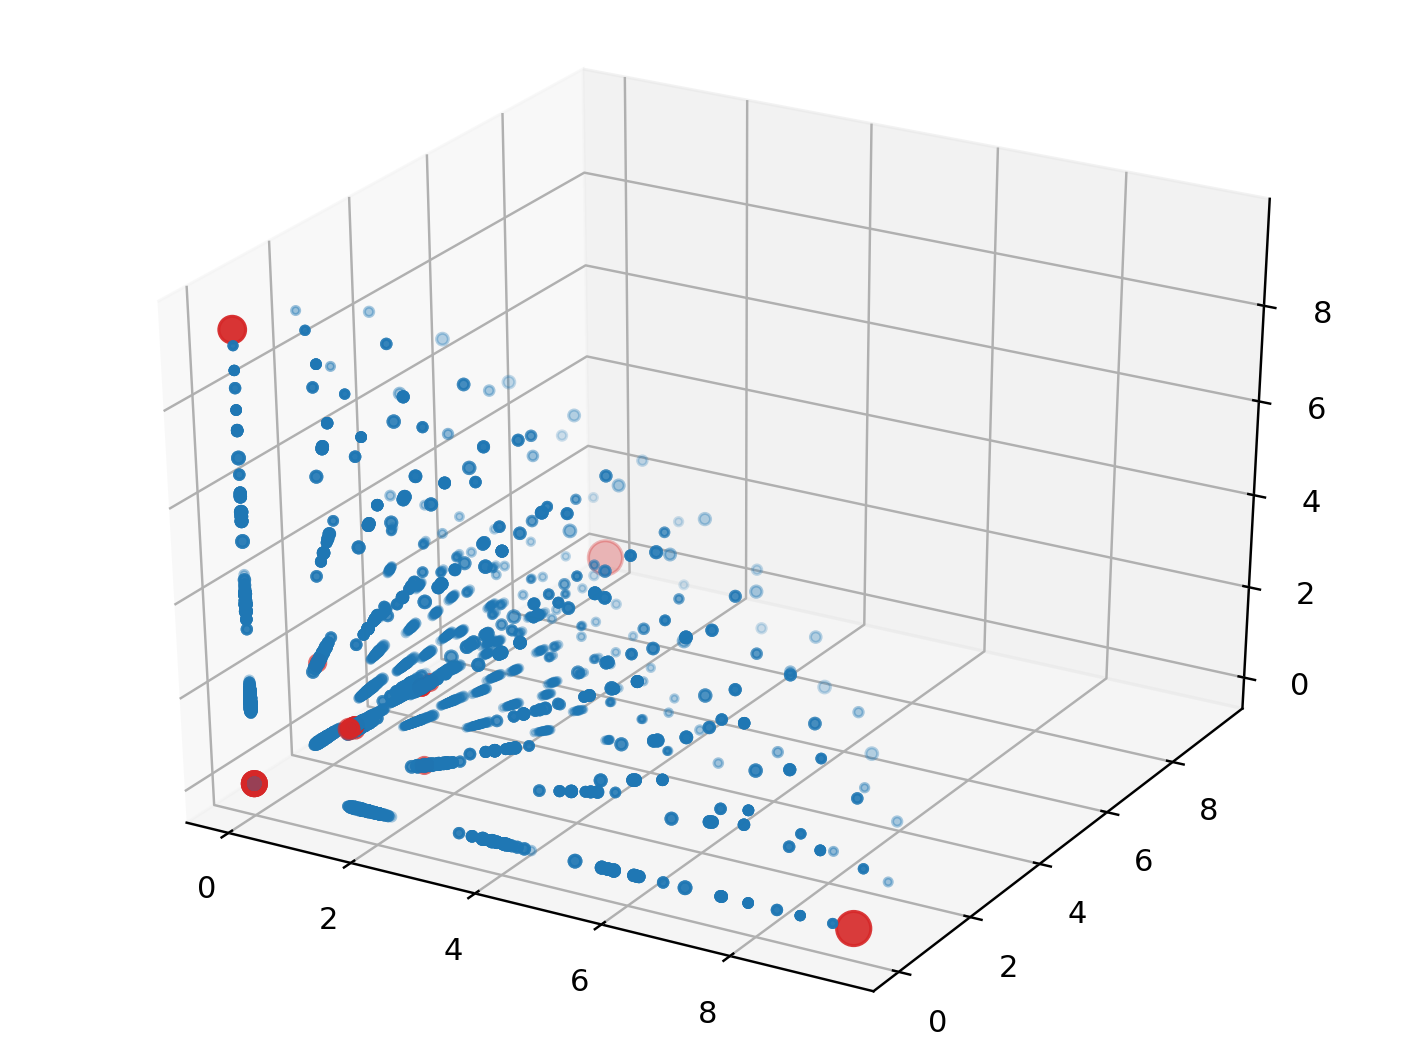

Projecting on a simplex and collapsing.
Computing depth contour 0 ...
Computing depth contour 1 ...
Computing depth contour 2 ...
Computing depth contour 3 ...
Computing depth contour 4 ...
Computing depth contour 5 ...
Computing depth contour 6 ...
Computing depth contour 7 ...
Computing depth contour 8 ...
Done.


In [3]:
sys.path.append('../../')
from vis.utils import dm
from vis.plotting.utils import resize_by_tradeoff, default_color, \
                                color_by_cv, enhance_color
from vis.tda import simple_shape
from vis.utils import io

eps = dm.epsilons

srcpf = 'debmdk-nbi'
destpf = 'debmdk-dense-nbi'
dim = '8d'

srcpathf = "../../data/{0:s}/{1:s}/dataf.csv".format(srcpf, dim)
destpathf = "./data/{0:s}/{1:s}/dataf.csv".format(destpf, dim)
if os.path.exists(srcpathf):
    spath, filenamef = os.path.split(srcpathf)
    dirs = spath.split('/')
    frontname = dirs[-2]
    dpath, _ = os.path.split(destpathf)
    os.makedirs(dpath, exist_ok=True) 

    print("Loading PF.")
    F = np.loadtxt(srcpathf, delimiter=',')
    print(srcpathf, F.shape, dirs, frontname)
    print("Loading PS.")
    X = np.loadtxt(os.path.join(spath, 'datax.csv'), delimiter=',')
    print(os.path.join(spath, 'datax.csv'), X.shape, dirs, frontname)
    
    print("Generating PF.")
    H,G = debmdk_knee_region(n=2100, m=int(dim[0]), lb=0.2, ub=0.8, d=-0.1)
    F = np.vstack((F,G))
    X = np.vstack((X,H))
    np.savetxt(destpathf, F, delimiter=',', fmt="%1.4e")
    np.savetxt(os.path.join(dpath, 'datax.csv'), X, delimiter=',', fmt="%1.4e")
    
    print("Computing Mu.")
    Mu,Ik = dm.tradeoff(F, epsilon=eps[dim], penalize_extremes=False)
    mupathf = os.path.join(dpath, "mu.csv")
    np.savetxt(mupathf, Mu, delimiter=',', fmt="%1.4e")
    muidxpathf = os.path.join(dpath, "muid.csv")
    np.savetxt(muidxpathf, Ik, delimiter=',', fmt="%d")
    
    # default color array
    C = default_color(F.shape[0], alpha=0.5)
    # change the size w.r.t. Mu, the values are 
    # too big for smaller size plots, so we make 
    # them half.
    S = resize_by_tradeoff(Mu, k=Ik)
    # enhance the knees with red
    C = enhance_color(C, k=Ik)

    print("Plotting.")
    ax = Axes3D(plt.figure())
    ax.scatter(F[:,0], F[:,1], F[:,2], s=S, c=C)
    plt.show()
    
    # Compute depth contours
    L = simple_shape.depth_contours(F, verbose=True)
    # save the layers
    io.savetxt(os.path.join(dpath, "depth-cont-cvhull.csv"), L, fmt='{:d}', delimiter=',')

In [4]:
# Now do paletteviz and check
sys.path.append('../../')
from vis.plotting.utils import resize_by_tradeoff, color_by_dist, color_by_cv, enhance_color

def load_props(path):
    r"""
    Load CV, Mu, Ik and S from path.
    """
    CV = None
    cvpathf = os.path.join(path, "datacv.csv")
    if os.path.exists(cvpathf):
        CV = np.loadtxt(cvpathf)

    # load the Mu values
    Mu = None
    mupathf = os.path.join(path, "mu.csv")
    if os.path.exists(mupathf):
        Mu = np.loadtxt(mupathf)

    # load the knee indices
    Ik = None
    kpathf = os.path.join(path, "muid.csv")
    if os.path.exists(kpathf):
        Ik = np.loadtxt(kpathf, dtype = int)
        
    return CV, Mu, Ik

def decide_size_color(CV, Mu, Ik):
    r"""
    Decide point-size and color from `CV`, `Mu` and `Ik`
    """
    # decide point-size
    S = 1
    if Mu is not None and Ik is not None:
        S = resize_by_tradeoff(Mu, k=Ik)

    # decide colors
    # C = default_color(F.shape[0], alpha=0.5)
    M = np.mean(F, axis=0)
    C, _ = color_by_dist(F, M, 0.15)
    
    # if CV is available, use CV to color
    if CV is not None:
        C = color_by_cv(CV, 0.15)

    # enhance knee points
    if Ik is not None:
        C = enhance_color(C, Ik)
    return S, C

./data/debmdk-dense-nbi/8d/dataf.csv (5083, 8) ['.', 'data', 'debmdk-dense-nbi', '8d'] debmdk-dense-nbi


<IPython.core.display.Javascript object>


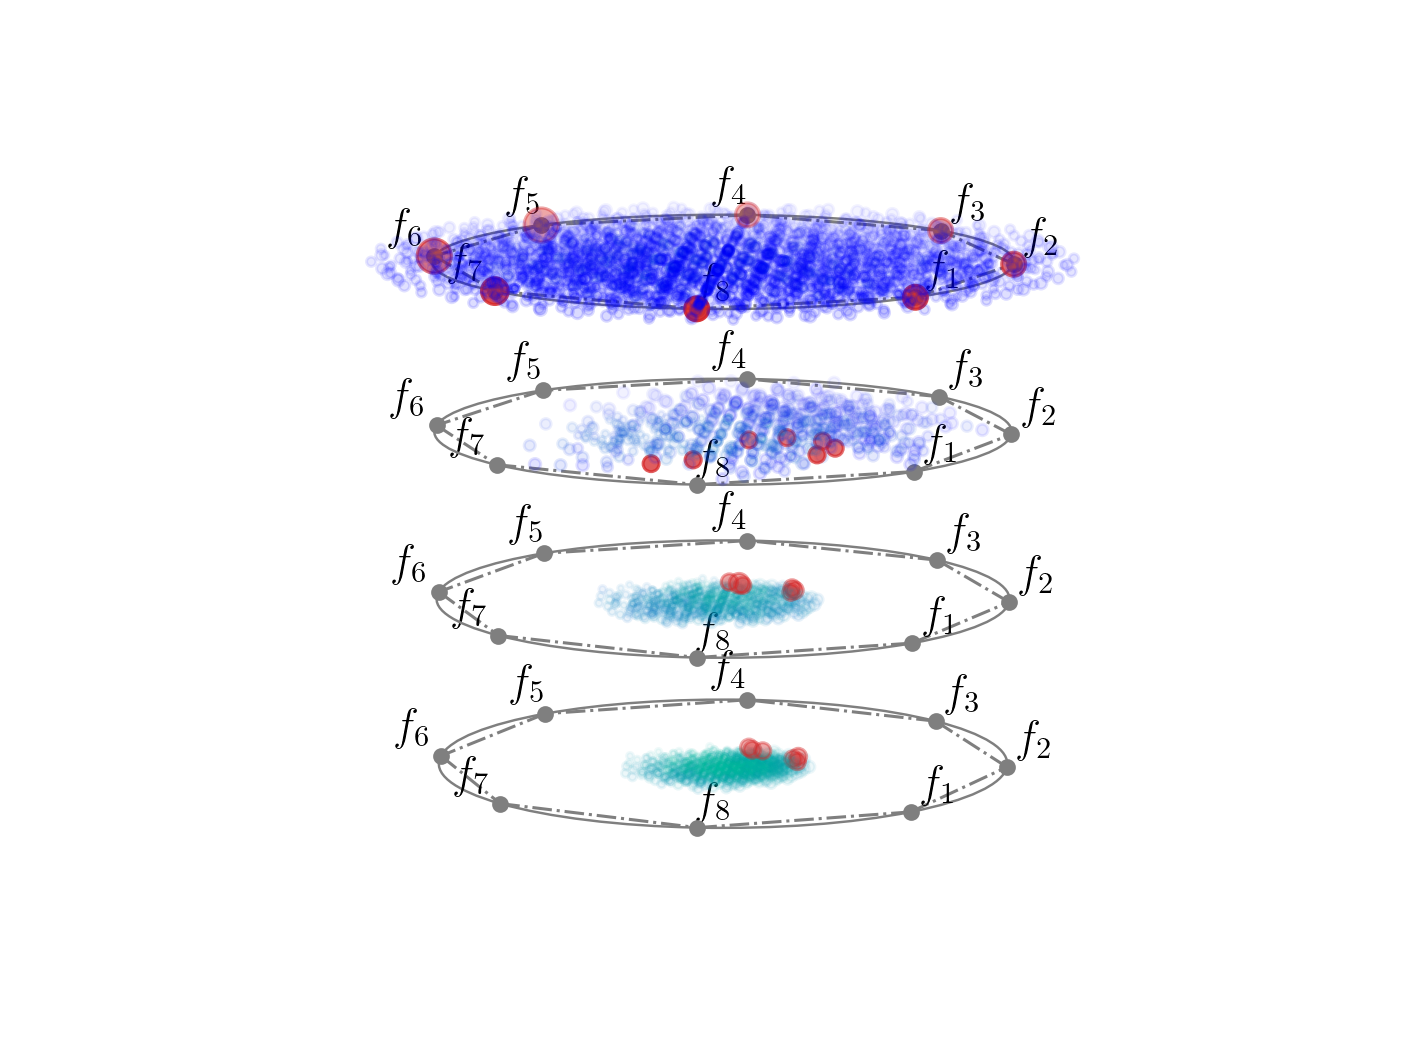

Plotting palette-star-viz.
Loading depth contours from ./data/debmdk-dense-nbi/8d/depth-cont-cvhull.csv.


In [5]:
%matplotlib notebook
sys.path.append('../../')
from vis.plotting import paletteviz
from vis.plotting.paletteviz import camera_angles_star

pf,dim = 'debmdk-dense-nbi', '8d'

fullpathf = "./data/{0:s}/{1:s}/dataf.csv".format(pf, dim)
if os.path.exists(fullpathf):
    path, filenamef = os.path.split(fullpathf)
    dirs = path.split('/')
    frontname = dirs[-2]

    # load the front
    F = np.loadtxt(fullpathf, delimiter=',')
    print(fullpathf, F.shape, dirs, frontname)

    CV, Mu, Ik = load_props(path)
    S,C = decide_size_color(CV, Mu, Ik)

    pdffigpath = os.path.join(path, "palette-starviz.pdf")
    svgfigpath = os.path.join(path, "palette-starviz.svg")
    depth_contour_path = os.path.join(path, "depth-cont-cvhull.csv")
    with plt.rc_context({"text.usetex": True, "font.size": 12}):
        paletteviz.plot(F, ax=Axes3D(plt.figure()), depth_contours=depth_contour_path, mode='star', \
                        n_partitions=4, s=S, c=C, euler=(-40,15), verbose=True) #camera_angles_star[pf][dim])
        
        # try to remove white space as much as possible
        plt.subplots_adjust(top=0.01, bottom=0, right=0.01, left=0, hspace=0, wspace=0)
        plt.margins(0,0,0)
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator())
        plt.gca().zaxis.set_major_locator(plt.NullLocator())
        
        # save the fig
        plt.savefig(pdffigpath, bbox_inches='tight', dpi=150, pad_inches=0)
        
        # show
        plt.show()